In [133]:
# Import necessary libraries
import time
from pathlib import Path

import gspread
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore

# Constants
COLUMN_ORDER = [
    "Player",
    "Team",
    "Position",
    "GP",
    "D Points",
    "Goals",
    "Total Assists",
    "Shots",
    "Special Teams Points",
    "Hits",
    "Shots Blocked",
    "Takeaways",
    "Faceoffs Won",
    "TOI",
]
NUM_PLAYERS = 300
URL_ALL_STRENGTHS, URL_EVEN_STRENGTH = (
    "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL",
    "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=ev&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL",
)
URL_FBL_FANTRAX = "https://www.fantrax.com/fantasy/league/1papyorqllbhqzl7/players;statusOrTeamFilter=ALL;pageNumber=1"


In [134]:
# Load data
def load_data(file_path):
    # File path.. Path...
    file = Path(file_path)
    # 1 hour = 3600 seconds
    hour = 3600
    # Check if the file exists
    if file.exists():
        # Get the modification time of the CSV
        modtime = file.stat().st_mtime
        # Get the current time
        current_time = time.time()
        # If the file is less than an hour old, load it else scrape the data
        dataframe = pd.read_csv(file_path, index_col=0) if current_time - modtime < hour else scrape_data(file_path)
    # If the file doesn't exist, scrape the data
    else:
        dataframe = scrape_data(file_path)

    return dataframe


In [135]:
# Scrape data
def scrape_data(file_path):
    # Set the URL based on the file path
    if file_path == "all_strengths.csv":
        url = URL_ALL_STRENGTHS
    elif file_path == "even_strength.csv":
        url = URL_EVEN_STRENGTH
    # Scrape the data
    dataframe = pd.read_html(url, index_col=0)[0]
    # Save to csv
    dataframe.to_csv(file_path)

    return dataframe


In [136]:
# This will be used to scrape data from Fantrax
def scrape_fantrax():
    pass


In [137]:
# Add D and STP column
def add_d_and_stp(df_all, df_even):
    # Add D and STP columns
    df_all["D Points"] = np.where(df_all["Position"] == "D", df_all["Total Points"], 0)
    df_all["Special Teams Points"] = df_all["Total Points"] - df_even["Total Points"]

    return df_all


In [138]:
# Add things for cleaning data if needed
def clean_data(dataframe):
    # Create a unique ID for each player to avoid issues with same name players
    dataframe["UID"] = dataframe.groupby("Player").cumcount()

    return dataframe


In [139]:
# Analyze data
def analyze_data(dataframe):
    # Make a copy of the dataframe to avoid modifying the original data
    dataframe = dataframe.copy()

    # Start index at 1 for better readability (Python usually starts indexing at 0)
    dataframe.index = dataframe.index + 1

    # List of categories to analyze
    categories = [
        "D Points",
        "Goals",
        "Total Assists",
        "Shots",
        "Special Teams Points",
        "Hits",
        "Shots Blocked",
        "Takeaways",
        "Faceoffs Won",
        "TOI",
    ]

    # Calculate z-scores for overall season statistics
    # Z-scores standardize data to have mean of 0 and standard deviation of 1
    for category in categories:
        dataframe[category] = pd.to_numeric(dataframe[category], errors="coerce")
    filtered_data = dataframe[categories].apply(zscore)
    dataframe["Season Value"] = filtered_data.sum(axis=1)
    season_rankings = dataframe.sort_values("Season Value", ascending=False)

    # Normalize stats by games played
    # This gives per game statistics instead of total season statistics
    for category in categories:
        dataframe[category] = dataframe[category] / dataframe["GP"]

    # Calculate z-scores for per game statistics
    filtered_data = dataframe[categories].apply(zscore)
    dataframe["Per Game Value"] = filtered_data.sum(axis=1)
    per_game_rankings = dataframe.sort_values("Per Game Value", ascending=False)

    # Select and order columns
    # This makes the data easier to read and understand
    season_rankings = season_rankings.loc[:, ["Season Value", *COLUMN_ORDER]]
    per_game_rankings = per_game_rankings.loc[:, ["Per Game Value", *COLUMN_ORDER]]

    # Add 'Rank' Column
    # This gives a ranking to each player based on their season or per game value
    season_rankings.insert(0, "Rank", range(1, len(season_rankings) + 1))
    per_game_rankings.insert(0, "Rank", range(1, len(season_rankings) + 1))

    # Return the rankings for both season and per game statistics
    return season_rankings, per_game_rankings


In [140]:
def find_value(season_rankings, per_game_rankings):
    gp_min = 5
    # Ensure Player and UID is set as index for both dataframes
    season_rankings = season_rankings.set_index("Player")
    per_game_rankings = per_game_rankings.set_index("Player")
    # Filter out players who have played 5 games or less
    season_rankings = season_rankings[season_rankings["GP"] > gp_min]
    per_game_rankings = per_game_rankings[per_game_rankings["GP"] > gp_min]
    # Calculate discrepancy in value
    discrepancy = (per_game_rankings["Per Game Value"] - season_rankings["Season Value"])
    # Create a new DataFrame for discrepancy
    discrepancy_df = discrepancy.to_frame(name="Discrepancy")
    # Filter players where Per Game Value is higher than Season Value
    filtered_discrepancy = discrepancy_df[discrepancy_df["Discrepancy"] > 0]
    # sort player by discrepancy
    sorted_discrepancy = filtered_discrepancy.sort_values("Discrepancy", ascending=False)
    # Select and return the top 50 players
    return sorted_discrepancy.head(50)


In [141]:
# Format and print dataframe
def format_and_print(dataframe):
    # Nested function to color rows
    # This function is used to apply a style to the DataFrame
    def color_rows(s):
        # Use a list comprehension to create a list of styles
        # If the row index is even, the background color will be #44475a
        # If the row index is odd, the background color will be #282a36
        return ["background-color: #44475a" if i % 2 else "background-color: #282a36" for i in range(len(s))]

    # Apply the color_rows function to the DataFrame
    # This will color the rows according to the rules defined in color_rows
    # The hide method is used to hide the index of the DataFrame
    return dataframe.style.apply(color_rows).hide_index()

In [142]:
# Visualize rankings
def visualize_top_50_discrepancy(season_rankings, per_game_rankings):
    # Get top 50 players by discrepancy
    # The find_value function is expected to return a DataFrame of the top 50 players by discrepancy
    top_50_players = find_value(season_rankings, per_game_rankings)

    # Sort players by discrepancy in ascending order
    # This makes it easier to see which players have the largest discrepancy
    top_50_players = top_50_players.sort_values(by="Discrepancy", ascending=True)

    # Create horizontal bar plot
    # The figure size is set to 10x10 for better visibility
    plt.figure(figsize=(10, 10))
    # The y-values are the player names (index of top_50_players)
    # The x-values are the discrepancy values
    bars = plt.barh(top_50_players.index, top_50_players["Discrepancy"])

    # Add discrepancy values at the end of each bar
    # This makes it easier to see the exact discrepancy value for each player
    for bar in bars:
        xval = bar.get_width()
        # The text is positioned at the end of the bar, in the middle vertically
        plt.text(xval, bar.get_y() + bar.get_height() / 2, round(xval, 2), va="center")

    # Set the title of the plot and the labels of the x and y axes
    plt.title("Top 50 Players by Discrepancy")
    plt.xlabel("Discrepancy")
    plt.ylabel("Player")

    # Display the plot
    plt.show()


In [143]:
# Output to Google Sheets
def output_to_gsheets(dataframe, worksheet_name, column_order):
    gc = gspread.oauth()
    sh = gc.open("FantasyStats")

    # Get the worksheet or create it if it doesn't exist
    try:
        worksheet = sh.worksheet(worksheet_name)
    except gspread.exceptions.WorksheetNotFound:
        worksheet = sh.add_worksheet(title=worksheet_name, rows="400", cols="25")

    # Clear the worksheet
    worksheet.clear()
    # Convert the index to a column
    dataframe = dataframe.reset_index(level=0)

    # Reorder the columns
    dataframe = dataframe.reindex(columns=column_order)

    # Update the worksheet with the DataFrame data
    worksheet.update(values=[dataframe.columns.to_numpy().tolist(), *dataframe.to_numpy().tolist()], range_name=None)


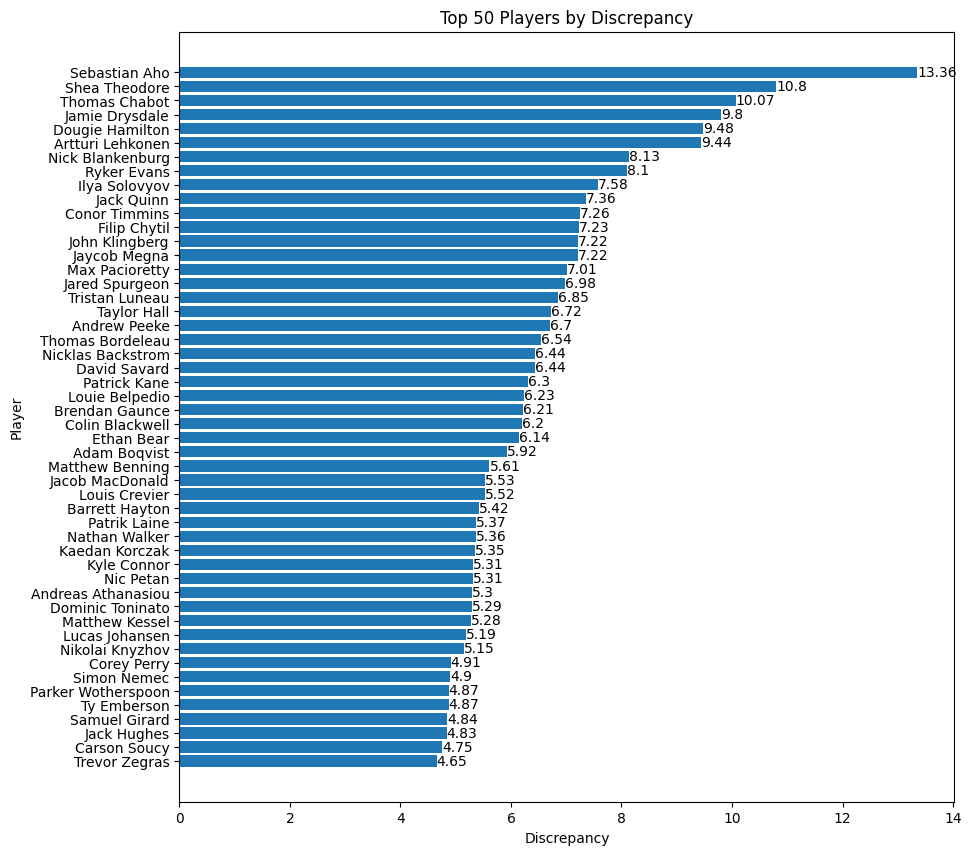

C:\Users\holym\AppData\Local\Temp\ipykernel_21712\1885234302.py:21: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(values=[dataframe.columns.to_numpy().tolist(), *dataframe.to_numpy().tolist()], range_name=None)
C:\Users\holym\AppData\Local\Temp\ipykernel_21712\1885234302.py:21: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(values=[dataframe.columns.to_numpy().tolist(), *dataframe.to_numpy().tolist()], range_name=None)


In [144]:
# Main function
def main():
    all_strengths = load_data("all_strengths.csv")
    even_strength = load_data("even_strength.csv")
    all_stats_df = add_d_and_stp(all_strengths, even_strength)
    season_rankings, per_game_rankings = analyze_data(all_stats_df)
    visualize_top_50_discrepancy(season_rankings, per_game_rankings)
    output_to_gsheets(season_rankings, "Season Rankings", ["Rank", "Season Value", *COLUMN_ORDER])
    output_to_gsheets(per_game_rankings, "Per Game Rankings", ["Rank", "Per Game Value", *COLUMN_ORDER])


# Run the main function
if __name__ == "__main__":
    main()
